# only basic packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import filters
%matplotlib inline


# load variables
F.npy  - raw fluorescence traces <br>
Fneu.npy  - raw neuropil traces <br>
behavior.npy - basic behavior and the identity of the conditioned neuron <br>
<br>
variables is behavior.npy:<br>
variable (dimensions): explanation <br>
'motor_steps' (frame number x 1): number of lickport motor steps in each frame<br>
'trial_start'(frame number x 1): frame where the mouse gets the sound cue and the closed loop epoch begins <br>
'reward' (frame number x 1): frame where the mouse receives the water reward <br>
'lick' (frame number x 1): frames where the mouse licks the lickport <br>
'threshold_crossing'(frame number x 1): frames where the lickport crosses the threshold distance, after this the mouse can initiate a reward with a lick <br>
'trial_number'(frame number x 1): trial identity of each frame <br>
'conditioned_neuron_index' (1): index of conditioned neuron <br>
'frame_rate' (1): frame rate in Hz<br>
'trial_lickport_step_size' (trial number x 1): size of a "motor_step" in mm <br>
'trial_lickport_travel_distance'(trial number x 1): total distance the lickport has to travel for a reward<br>
'trial_start_times'(trial number x 1): real time of trial starts (to calculate reward/minute)<br>
'trial_hit'(trial number x 1): True if the mouse gets a reward, False otherwise<br>
'trial_miss' (trial number x 1): True if the lickport does not pass the thresold distance in the trial, False otherwise<br>
'trial_ignore'(trial number x 1): True if the lickport passes the threshold distance but the mouse doesn't initiate a reward with a lick (the mouse does the task but is sated and doesn't need water<br>
'trial_reward_size'(trial number x 1): The valve time for the water reward, this number correlates with the size of the reward the mouse receives<br>
<br>
iscell.npy - semi-automatic classification of all ROIs, only a fraction of ROIs are actually cells <br>
spks.npy - deconvolved spike probabilities <br>
ops.npy - technical parameters of the imaging experiment <br>
stat.npy - information on each ROI (location on the image, size, shape, etc) <br>

In [2]:
source_dir = '/home/rozmar/Data/Calcium_imaging/BCI_export/KayvonScope/BCI_03/050521'
F = np.load(os.path.join(source_dir,'F.npy'))
Fneu = np.load(os.path.join(source_dir,'Fneu.npy'))
iscell = np.load(os.path.join(source_dir,'iscell.npy'))
behavior = np.load(os.path.join(source_dir,'behavior.npy'),allow_pickle = True).tolist()
ops = np.load(os.path.join(source_dir,'ops.npy'),allow_pickle = True).tolist()
stat = np.load(os.path.join(source_dir,'stat.npy'),allow_pickle = True).tolist()

# correct for neuropil and calculate F0
The following method is a bit involved, we apply a gaussian filter with a 10 frame sigma, then a min and max filter with a 60s window. This is the suite2p way, it eliminates slow drifts in the baseline.<br><br>
There are many ways to do this and we encourage you to try both this and a scalar F0.

In [3]:
sig_baseline = 10 
win_baseline = int(60*behavior['frame_rate'])
Fcorr= F-0.7*Fneu
to_correct = np.min(Fcorr,1)<1
Fcorr[to_correct,:] = Fcorr[to_correct,:]-np.min(Fcorr,1)[to_correct,np.newaxis]+1 # we don't allow anything to be below 0
Flow = filters.gaussian_filter(Fcorr,    [0., sig_baseline])
Flow = filters.minimum_filter1d(Flow,    win_baseline)
F0 = filters.maximum_filter1d(Flow,    win_baseline)
dF = Fcorr-Flow
dFF = (Fcorr-Flow)/Flow

Alternatively, you can go with a scalar F0, (e.g. 10th percentile of Fcorr above), which will keep the slow baseline changes which CAN be sustained low firing rate changes

this is how you select cells and the conditioned neuron

In [4]:
dff_conditioned_neuron = dFF[behavior['conditioned_neuron_index'],:]
stat_conditioned_neuron = np.asarray(stat)[behavior['conditioned_neuron_index']]
dFF_cells = dFF[iscell[:,0]==1,:]
stat_cells = np.asarray(stat)[iscell[:,0]==1]
sampling_rate = ops['fs']
meanImg = ops['meanImg']

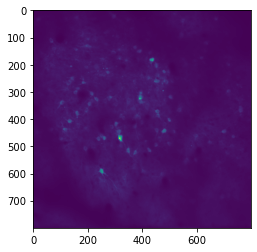

In [5]:
plt.imshow(meanImg)

this is where all the cells and the conditioned neuron is on the image

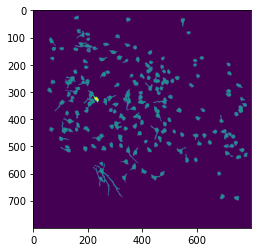

In [6]:
mask = np.zeros_like(meanImg)

for stat_now in stat_cells:
    mask[stat_now['ypix'],stat_now['xpix']] = 1
mask[stat_conditioned_neuron['ypix'],stat_conditioned_neuron['xpix']] = 2
plt.imshow(mask)

let's plot the df/f trace and the trial starts and reward times here <br>
green dots are trial starts <br>
red dots are when the mouse gets a reward <br>
the blue line in the bottom shows the movement of the lickport <br>

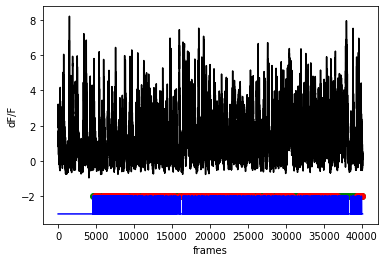

In [7]:
plt.plot(dff_conditioned_neuron,'k-')
plt.ylabel('dF/F')
plt.xlabel('frames')

go_cue_frames = np.where(behavior['trial_start']==1)[0]
reward_frames = np.where(behavior['reward']==1)[0]
plt.plot(go_cue_frames,np.zeros(len(go_cue_frames))-2,'go')
plt.plot(reward_frames,np.zeros(len(reward_frames))-2,'ro')
plt.plot(behavior['motor_steps']-np.max(behavior['motor_steps'])-2,'b-')


zoom

(-5.0, 6.0)

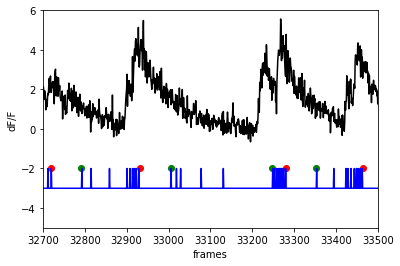

In [8]:
plt.plot(dff_conditioned_neuron,'k-')
plt.ylabel('dF/F')
plt.xlabel('frames')

go_cue_frames = np.where(behavior['trial_start']==1)[0]
reward_frames = np.where(behavior['reward']==1)[0]
plt.plot(go_cue_frames,np.zeros(len(go_cue_frames))-2,'go')
plt.plot(reward_frames,np.zeros(len(reward_frames))-2,'ro')
plt.plot(behavior['motor_steps']-np.max(behavior['motor_steps'])-2,'b-')
plt.xlim([32700,33500])
plt.ylim([-5,6])